In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

- Q1. Do smokers have higher insurance charges than non-smokers?
- Q2. Are men more likely to smoke than women?
- Q3. Do different regions have different charges, on average?

# Q1. Do smokers have higher insurance charges than non-smokers?

###  1. State your Null Hypothesis and Alternative Hypothesis

In [3]:
df = pd.read_csv('C:/Users/Dell/Downloads/insurance (1).csv')
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [4]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [5]:
smokers = df.loc[df['smoker'] == 'yes'].copy()
non_smokers = df.loc[df['smoker'] == 'no'].copy()

In [6]:
smokers_charge = smokers['charges']
non_smokers_charge = non_smokers['charges']

In [7]:
#find outliers in smokers charge
zscores= stats.zscore(smokers_charge)
outliers = abs(zscores)>3
np.sum(outliers)

0

In [8]:
#find outliers in non smokers charge 
zscores= stats.zscore(non_smokers_charge)
outliers = abs(zscores)>3
np.sum(outliers)

24

In [9]:
#remove outliers from non smokers charge 
non_charge = non_smokers_charge[~outliers]
non_charge

1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1040, dtype: float64

## Equal variance Test

In [10]:
test_result = stats.levene(smokers_charge, non_smokers_charge)
test_result

LeveneResult(statistic=332.6135162726081, pvalue=1.5593284881803726e-66)

In [11]:
test_result.pvalue<.05

True

## Final Test

In [12]:
test_result = stats.ttest_ind(smokers_charge, non_smokers_charge, equal_var = False)
test_result

Ttest_indResult(statistic=32.751887766341824, pvalue=5.88946444671698e-103)

In [13]:
test_result.pvalue<.05

True

<BarContainer object of 2 artists>

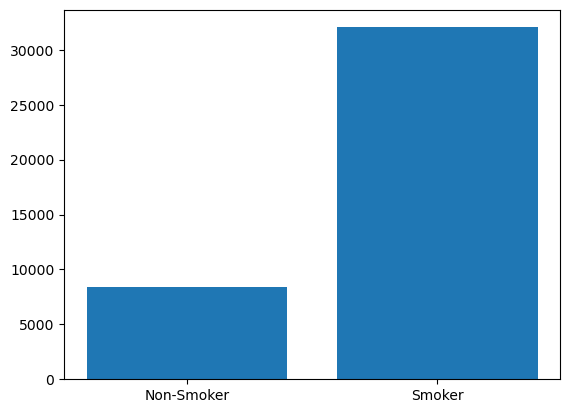

In [14]:
plt.bar(['Non-Smoker','Smoker'],[non_smokers_charge.mean(), smokers_charge.mean()])

# Q2. Are men more likely to smoke than women?

### State the Null Hypothesis and Alternative Hypothesis

Null Hypothesis: Men and women are equaly likely to be smokers

Alternative Hypothesis: Men or women are more likely to be smokers 

In [15]:
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [16]:
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result

In [17]:
print(p)
p<.05

0.006548143503580696


True

The p-value < 0.5 so the null value is rejected so, men or women are more likely to be smokers. 

<Axes: xlabel='sex', ylabel='Probability'>

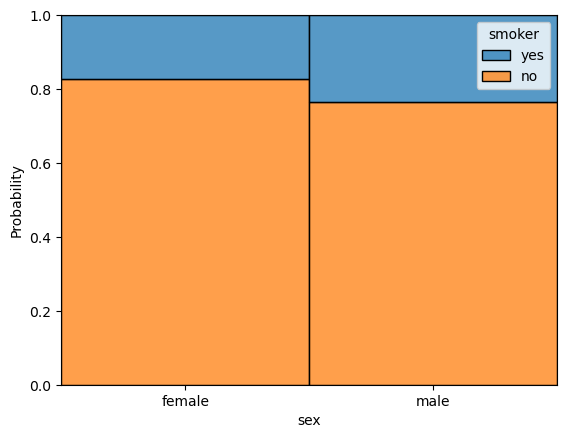

In [18]:
sns.histplot(data=df, x='sex', hue='smoker', stat='probability',multiple='fill')

Men are more likely to be smokers

# Q3. Do different regions have different charges, on average?

### State the Null Hypothesis and Alternative Hypothesis

Null Hypothesis: Insurance charges are the same across regions.

Alternative Hypothesis : Insurance charges are different across regions.

<Axes: xlabel='region', ylabel='charges'>

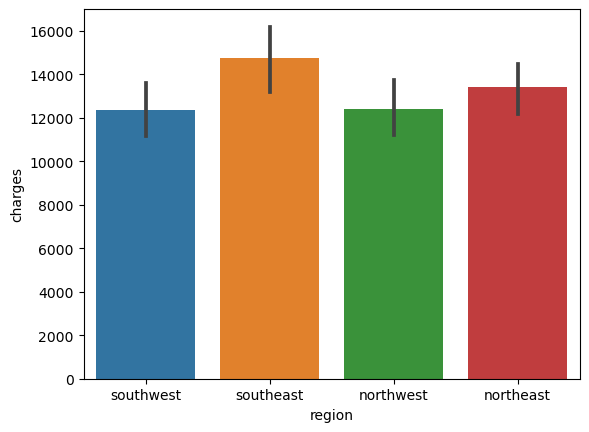

In [25]:
sns.barplot(data = df, x = 'region', y  = 'charges')

In [19]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

We have 4 groups of categorical data so the correct test is ANOVA

ANOVA test Assumptions: 

* Normality


* Equal variance


* No significant outliers

## Testing ANOVA assumptions 

In [20]:
groups = {}

## Loop through all unique categories
for region in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==region,'charges'].copy()

    # save into the dictionary
    groups[region] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

## Outliers

In [21]:
groups_clean = {}

for group, data in groups.items():
    
    ## Get series for group and rename
    outliers = np.abs(stats.zscore(data))>3
    n_outliers = np.sum(outliers)
    
    print(f"- For {group}, there were {n_outliers} outliers removed.")
    clean_data = data[~outliers]

    # save into the clean dictionary
    groups_clean[group] = clean_data
    
groups_clean.keys()

- For southwest, there were 8 outliers removed.
- For southeast, there were 2 outliers removed.
- For northwest, there were 7 outliers removed.
- For northeast, there were 4 outliers removed.


dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

## Normality

In [22]:
norm_results = []
for group, data in groups_clean.items():
    
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results.append({'group':group, 'n': len(data),
                         'p':p, 'test stat':stat, 'sig?':p<.05})
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results)
norm_results_df

,group,n,p,test stat,sig?
0,southwest,317,7.728611e-22,97.223886,True
1,southeast,362,1.936990e-13,58.544942,True
2,northwest,318,2.940543e-19,85.341045,True
3,northeast,320,3.557877e-17,75.749565,True


## Testing Assumption of Equal Variance 

In [23]:
res = stats.levene(*groups_clean.values())
res

LeveneResult(statistic=9.518349004554441, pvalue=3.2035503711783993e-06)

In [24]:
res.pvalue<.05

True

The null Hypothesis is false and insurances chareges are not the same accross regions 

### Interpret your p-value and reject or fail to reject your null hypothesis

In [26]:
res = stats.kruskal(*groups_clean.values())
res

KruskalResult(statistic=6.914045702545643, pvalue=0.07468847911322242)

In [27]:
res.pvalue<.05

False

As P-value is less than 0.5 we fail to reject the null hypothesis and there is no difference between regions 